In [14]:
'''
M. Eshraqi 2019 Apr 15
Twiss tracker. will start from a set of Twiss parameters and track them through a list of elements
v0.1 
Elements included: QUADT, QUADK, DRIFT, SBEND
v0.2
fixed the m matrix for n>1
v0.3
added particle tracking option
fixed the matrix calculations (Natalia Milas)
v0.4
fixed the creation of normalized distribution 
added interactive visualization of the alpha, beta and emittance
v0.5
moved plotting to a separate function (from each element)
v0.6
added project to ellipse
renamed track_plot to track_n_plot
made twiss_gamma function a lambda
v0.7
refactoring, moving the matrix multiplication to a new function
added normalizing to circle
added following a point on ellipse/circle
v0.8
fixed the warning caused by matplotlib when adding data to an existing plot (2021-Nov-11)
v0.9
work in progress: making subplots with different sizes for other info
''';
#https://yannis.web.cern.ch/yannis/teaching/transverse.pdf;

In [1]:
import numpy as np
import scipy.stats as sp
import pylab as plt
import ipywidgets as wg

from ipywidgets import interact

from matplotlib.patches import Rectangle
#from ess import SP_Relativity as SPR


# Functions to calculate lattice parameters

In [4]:
def twiss_matched(m_xyz: list=np.eye(2)):
    '''
    m_xyz: array 2x2
    returns the matched input Twiss parameters of the MX, MY matrices when called
    '''
    mu = phase_advance(m_xyz, False, False) 
    
    twiss_alpha = lambda m00, m11, mu: (m00-m11)/(2*np.sin(mu))
    twiss_beta = lambda m01, mu: m01/np.sin(mu)
    
    alpha = twiss_alpha(m_xyz[0,0], m_xyz[1,1], mu)
    beta = twiss_beta(m_xyz[0,1], mu)
    
    print('matched parameter: alpha: {:.3e}, beta: {:.3e}'.format(alpha, beta))
    return alpha, beta


def twiss_set(beta0x: float, alpha0x: float, emit0x: float, 
              beta0y: float, alpha0y: float, emit0y: float,
              beta0z: float, alpha0z: float, emit0z: float):
    '''
    Twiss                          #  0,  1,  2,  3 : b_x, a_x, g_x, e_x
                                   #  4,  5,  6,  7 : b_y, a_y, g_y, e_y
                                   #  8,  9, 10, 11 : b_z, a_z, g_z, e_z
                                   # 12, 13         : indicative x, xp
                                   # 14, 15         : indicative y, yp
                                   # 15, 16         : indicative z, zp

    '''
    
    twiss_gamma = lambda alpha, beta: (1+alpha**2)/beta
    
    #sqrt2half = 2**0.5/2
    #xi = xpi = yi = ypi = zi = zpi = sqrt2half
    
    xi = yi = zi = 1
    xpi = ypi = zpi = 0

    xi, xpi = project_to_ellipse(xi, xpi, emit0x, alphax0, betax0)
    yi, ypi = project_to_ellipse(yi, ypi, emit0y, alphay0, betay0)
    zi, zpi = project_to_ellipse(zi, zpi, emit0z, alphaz0, betaz0)
    
    gammax0 = twiss_gamma(alphax0, betax0)
    gammay0 = twiss_gamma(alphay0, betay0)
    gammaz0 = twiss_gamma(alphaz0, betaz0)
    twiss=np.array([[betax0,alphax0,gammax0,emit0x,
                     betay0,alphay0,gammay0,emit0y,
                     betaz0,alphaz0,gammaz0,emit0z,
                     xi, xpi, yi, ypi, zi, zpi]]).T
    return twiss

def phase_advance(m_xyz: list, degrees: bool=False, prnt: bool=False) -> float:
    '''
    parameters:
    m_xyz: array (2x2)
    degrees: boolean, if True returns the phase advances in degrees (default is False: returns in radians)
    prn: boolean, if True prints the phase advances (default is False)
    returns: 
    mu: float, phase advances of the m_xyz matrix when called
    '''

    mu = np.arccos(0.5*np.trace(m_xyz))
    if degrees:
        mu = np.degrees(mu)
        if prnt:
            print('mu: {:.3f} (deg)'.format(mu))
    else:
        if prnt:
            print('mu: {:.3f} (rad)'.format(mu))
    return mu

def project_to_ellipse(u_arr: list, up_arr: list, emit: float =1, alpha: float = 0, beta: float = 1):
    '''   
    creates a 2D particle distribution
    parameters:
    u_arr, up_arr: list, list; distribution in u and up planes on a unity circle
    emit: float, geometric emittance
    alpha: float, Twiss alpha
    beta: float > 0, Twiss beta
    returns:
    u_arr, distxp: list, list; distribution in u and up planes on the rotated ellipse
    read more:
    http://uspas.fnal.gov/materials/10MIT/Emittance.pdf#page=4

    '''
    u_arr *= (emit*beta)**0.5
    up_arr *= (emit*beta)**0.5
    up_arr = (up_arr - alpha * u_arr)/beta

    return u_arr, up_arr

def project_to_circle(u_arr: list, up_arr: list, emit: float =1, alpha: float = 0, beta: float = 1):
    '''   
    normalizes a 2D particle distribution to a circle
    parameters:
    u_arr, up_arr: list, list; distribution in u and up planes on a unity circle
    emit: float, geometric emittance
    alpha: float, Twiss alpha
    beta: float > 0, Twiss beta
    returns:
    u_arr, up_arr: list, list; distribution in u and up planes on the rotated ellipse
    read more:
    http://uspas.fnal.gov/materials/10MIT/Emittance.pdf#page=4

    '''
    u_arr /= (emit*beta)**0.5
    up_arr /= (emit*beta)**0.5
    up_arr = up_arr*beta + alpha*u_arr

    return u_arr, up_arr

def sqrt_sum_of_sq(a_arr: list, nD: int)-> float:
    '''
    square root of quadratic sum of element arrays
    parameters:
    a_arr: list containing elements to be summed up
    nD: int, limit of the elements to be added, elements [from zero to nD)
    returns:
    float
    '''
    s = 0
    for i in range(0, nD):
        s += a_arr[i] ** 2
    return s**0.5

# Creating a distribution and analysing the distribution

In [5]:
def gen_distrib(dist_type: str, nD: int, npart: int) -> list:
    '''
    parameters:
    dist_type: str, distribution type
    nD: int, number of dimensions
    npart: int, number of particles
    returns:
    an array of size (npart, nD)
    more info:
    'KV'  # KV: Uniform in a 4D sphere (for other dimensions the distribution is not KV)
    'WB'  # Water-bag: Uniformly distributed on the surface of a 4D sphere (for other dimensions it is not WB)
    'G0'  # Gaussian, no truncation 
    'XL'  # crossed-lines, a line on u-axis, between -r, r, and a similar line on u'-axis
    'PB'  # parabolic beam in each 2D plane
    '''
    disti = np.zeros((npart, nD))
    dist = np.zeros((npart, nD))

    for n in range(0,nD):
        disti[:,n]=np.random.normal(loc=0, scale=1, size=npart)

    dist_scaling=np.ones(npart)
    if dist_type =='WB':
        dist_scaling[:] = np.random.uniform(npart)
    
        
    if dist_type =='WB' or dist_type == 'KV': 
        j = 0
        #if nD==4:
        for i in range(0, npart):
            if sqrt_sum_of_sq(disti[i,:], nD)>0:
                scaling = dist_scaling[i]/sqrt_sum_of_sq(disti[i,:], nD)
                dist[j,:] = disti[i,:]*scaling
                j+=1

    elif dist_type[0]=='G':
        for n in range(0, nD):
            dist[:,n]=np.random.normal(loc=0, scale=1, size=npart)

    elif dist_type == 'XL':
        half = int(npart/2)
        dist[:half,0] = np.linspace(-1, 1, half)
        np.random.shuffle(dist[:half,0])
        dist[half:,1] = np.linspace(-1, 1, half)
        np.random.shuffle(dist[half:,1])
        if nD==4:
            dist[:half,2] = np.linspace(-1, 1, half)
            np.random.shuffle(dist[:half,2])
            dist[half:,3] = np.linspace(-1, 1, half)
            np.random.shuffle(dist[half:,3])
            
    elif dist_type == 'PB': # parabolic beam
        for n in range (0, int(nD/2)):
            r=np.random.uniform(0, 1, npart)
            r=r**0.5
            t=np.random.uniform(0, 2*np.pi, npart)
            dist[:,2*n+0] = r*np.cos(t)
            dist[:,2*n+1] = r*np.sin(t)
        
    return dist

def plot_2D_projection(u_arr: list, up_arr: list):
    '''
    plots a 2D distribution and the projections in each axis
    parameters:
    u_arr: list, array containing the u values
    up_arr: list, array containing the u' values
    '''

    fit_parabolic = True

    # definitions for the axes
    left, width = -2, 2
    left, width = -2, 2
    bottom, height = -2, 2
    bottom_h = left_h = left+width+0.2

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.5]
    rect_histy = [left_h, bottom, 0.5, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(2,2))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # the scatter plot:
    axScatter.scatter(u_arr[:], up_arr[:], 0.5)

    # now determine nice limits by hand:
    xymax = max( [max(u_arr[:]), max(up_arr[:])] )
    binwidth = xymax/20
    lim = ( int(xymax/binwidth) + 1) * binwidth

    axScatter.set_xlim( (-lim, lim) )
    axScatter.set_ylim( (-lim, lim) )

    bins = np.arange(-lim, lim + binwidth, binwidth)
    axHistx.hist(u_arr[:], bins=bins)
    axHisty.hist(up_arr[:], bins=bins, orientation='horizontal')
    if fit_parabolic:
        dummy, x_bin_max = axHistx.get_ylim()
        axHistx.plot(u_arr[:], x_bin_max-x_bin_max*u_arr[:]**2, '.')
        dummy, xp_bin_max = axHisty.get_xlim()
        axHisty.plot(xp_bin_max-xp_bin_max*up_arr[:]**2, up_arr[:], '.')

    axHistx.set_xlim(axScatter.get_xlim());
    axHisty.set_ylim(axScatter.get_ylim());
    
    
#nD = 4
#npart = 1000
#dist = gen_distrib('PB', nD, npart)
#print(np.shape(dist))
#plot_2D_projection(dist[:,0], dist[:,1])

def create_2d_obsolete(emit: float = 1, alpha: float = 0, beta: float = 1, 
              npart: int = 1000, energy: float = 0, mass: float = 0) -> list:
    '''   
    creates a 2D particle distribution
    parameters:
    emit: float, geometric emittance
    alpha: float, Twiss alpha
    beta: float > 0, Twiss beta
    npart: int, number of particles in distribution
    returns:
    u, up: list, list; distribution in u and up planes
    '''    
    if energy!=0:
        if mass ==0:
            print('mass should be given')
        else:
            rel_bg = SPR.beta(energy, mass)*SPR.gamma(energy, mass)
            emit = emit/rel_bg
            emit = emit/rel_bg

    r=np.random.rand(npart)
    t=np.random.rand(npart)*2*np.pi
    
    u=r*np.cos(t)
    up=r*np.sin(t)
    
    u, up = project_to_ellipse(u, up, emit, alpha, beta)

    return (u, up)

def create_nd(dist_type: str = 'KV', nD: int=4, npart: int = 1000, 
              emit1: float = 1, alpha1: float = 0, beta1: float = 1, 
              emit2: float = 1, alpha2: float = 0, beta2: float = 1, 
              emit3: float = 1, alpha3: float = 0, beta3: float = 1) -> list:
    '''   
    creates a nD particle distribution
    parameters:
    dist_type: str, distribution type (KV, WB, G0, XL, PB)
    nD: int, number of dimensions
    npart: int, number of particles in distribution
     the following 3 parameters should be repeated per pair of dimensions
    # emit: float, geometric emittance
    # alpha: float, Twiss alpha
    # beta: float > 0, Twiss beta

    returns:
    distrib, list, all the distributions
    '''    

    global mass
    global energy
    
    dummy_dist = gen_distrib(dist_type, nD, npart)
    
    if nD == 6:
        dummy_dist[:, 0], dummy_dist[:, 1] = project_to_ellipse(dummy_dist[:, 0], dummy_dist[:, 1], emit1, alpha1, beta1)
        dummy_dist[:, 2], dummy_dist[:, 3] = project_to_ellipse(dummy_dist[:, 2], dummy_dist[:, 3], emit2, alpha2, beta2)
        dummy_dist[:, 4], dummy_dist[:, 5] = project_to_ellipse(dummy_dist[:, 4], dummy_dist[:, 5], emit3, alpha3, beta3)
    elif nD == 4:
        dummy_dist[:, 0], dummy_dist[:, 1] = project_to_ellipse(dummy_dist[:, 0], dummy_dist[:, 1], emit1, alpha1, beta1)
        dummy_dist[:, 2], dummy_dist[:, 3] = project_to_ellipse(dummy_dist[:, 2], dummy_dist[:, 3], emit2, alpha2, beta2)
    elif nD == 2:
        dummy_dist[:, 0], dummy_dist[:, 1] = project_to_ellipse(dummy_dist[:, 0], dummy_dist[:, 1], emit1, alpha1, beta1)
        
    return dummy_dist

            
def twiss_from_distrib(distribution: tuple) -> tuple:
        (u, up) = distribution
        u_rms2 = np.average((u - np.average(u))**2)
        up_rms2 = np.average((up - np.average(up))**2)
        uup_rms = np.average((u - np.average(u))*(up - np.average(up)))
        
        emit_dist = np.sqrt(u_rms2 * up_rms2 - uup_rms**2)
        
        beta_dist = up_rms2/emit_dist
        gamma_dist = up_rms2/emit_dist
        alpha_dist = -uup_rms/emit_dist
        
        print('emittance of the distribution is: {:0.3f}'.format(emit_dist))
        print('alpha: {}, beta: {}, gamma: {}'.format(alpha_dist, beta_dist, gamma_dist))
        return (emit_dist, alpha_dist, beta_dist)


# Multiplication of matrices

In [6]:
def R_matrix(m_mtr: list):
    '''
    parameters:
    m_mtr: square array, the 2x2 transfer matrix of the element

    returns:
    R: square array, 3x3 R matrix
    | beta2  |   | R11 ** 2     -2.R11.R12      R12 ** 2 |   | beta1  |
    |        |   |                                       |   |        |
    | alpha2 | = | -R11.R21   R11.R22+R12.R21   -R12.R22 | . | alpha1 | 
    |        |   |                                       |   |        |
    | gamma2 |   | R21 ** 2     -2.R21.R22      R22 ** 2 |   | gamma1 | 
    '''
    R=np.zeros((3,3))
    
    R[0,0] = m_mtr[0,0]**2
    R[0,1] = -2*m_mtr[0,0]*m_mtr[0,1]
    R[0,2] = m_mtr[0,1]**2
    
    R[1,0] = -m_mtr[0,0]*m_mtr[1,0]
    R[1,1] = m_mtr[0,0]*m_mtr[1,1] + m_mtr[0,1]*m_mtr[1,0]
    R[1,2] = -m_mtr[0,1]*m_mtr[1,1]
    
    R[2,0] = m_mtr[1,0]**2
    R[2,1] = -2*m_mtr[1,0]*m_mtr[1,1]
    R[2,2] = m_mtr[1,1]**2
    
    return R


def matrix_multiply(mx: list=np.eye(2), my: list=np.eye(2), mz: list=np.eye(2), ele_type:int=0, dl: float=0, n:int=1) -> list:
    '''
    tws, FTA                           #  2,  3,  4,  5 : b_x, a_x, g_x, e_x
                                       #  6,  7,  8,  9 : b_y, a_y, g_y, e_y
                                       # 10, 11, 12, 13 : b_z, a_z, g_z, e_z
                                       # 14, 15         : indicative x, xp
                                       # 16, 17         : indicative y, yp
                                       # 18, 19         : indicative z, zp
                                       
                                       
    Twiss                              #  0,  1,  2,  3 : b_x, a_x, g_x, e_x
                                       #  4,  5,  6,  7 : b_y, a_y, g_y, e_y
                                       #  8,  9, 10, 11 : b_z, a_z, g_z, e_z
                                       # 12, 13         : indicative x, xp
                                       # 14, 15         : indicative y, yp
                                       # 15, 16         : indicative z, zp

    '''
    global twiss
    global MX
    global MY
    global MZ
    global full_twiss_array

    tws = np.zeros((20, n+1))          # 14,15: indicative x, xp
                                       # 16,17: indicative y, yp
                                       # 18,19: indicative z, zp

    if len(full_twiss_array[0,:])==0:   # 0: z
        tws[0,0]=0
    else:
        tws[0,0] = full_twiss_array[0,-1]  
    tws[1,:] = ele_type                #  1: element type
    tws[2:20,[0]] = twiss              #  2,  3,  4,  5 : b_x, a_x, g_x, e_x
                                       #  6,  7,  8,  9 : b_y, a_y, g_y, e_y
                                       # 10, 11, 12, 13 : b_z, a_z, g_z, e_z

    r_mx = R_matrix(mx)
    r_my = R_matrix(my)
    r_mz = R_matrix(mz)
    
    for i in range (1,n+1):
        twiss[0: 3]=r_mx.dot(twiss[0: 3]) # x_twiss parameters
        twiss[3]=twiss[3]                 # x_emit
        twiss[4: 7]=r_my.dot(twiss[4: 7]) # y_twiss parameters
        twiss[7]=twiss[7]                 # y_emit
        twiss[8:11]=r_my.dot(twiss[8:11]) # z_twiss parameters
        twiss[11]=twiss[11]               # z_emit

        twiss[12:14]=mx.dot(twiss[12:14]) # 14,16: indicative x, xp
        twiss[14:16]=my.dot(twiss[14:16]) # 16,18: indicative y, yp
        twiss[16:18]=mz.dot(twiss[16:18]) # 18,20: indicative z, zp

        tws[ 2: 6,[i]] = twiss[0:4]       
        tws[ 6:10,[i]] = twiss[4:8]       
        tws[10:14,[i]] = twiss[8:12]      
        tws[14:20,[i]] = twiss[12:18]      

        tws[0,i] = tws[0,i-1] + dl
    z = tws[0,n]

    mx = np.linalg.matrix_power(mx, n)
    my = np.linalg.matrix_power(my, n)
    mz = np.linalg.matrix_power(mz, n)

    MX = mx.dot(MX)
    MY = my.dot(MY)
    MZ = mz.dot(MZ)
    
    full_twiss_array = np.append(full_twiss_array, tws, axis=1)

    global trk
    
    if trk:    
        track_n_plot(mx, my, z)    
    return tws
    

# Creating the matrices

In [7]:
def DRIFT(L: float, n: int=1):
    '''
    L: float, Length of the drift 
    n: int, number of steps in the drift
    returns an array of the twiss parameters and the z in the element and plots x(red) and y(blue)
    
    | 1    L |
    |        |
    | 0    1 | 
    
    '''
    
    ele_type = 0
    dl = L/n
    mx = np.array([[1, dl],[0, 1]])
    my = np.array([[1, dl],[0, 1]])
    mz = np.array([[1, dl],[0, 1]])
    tws = matrix_multiply(mx, my, mz, ele_type, dl, n)

    return tws

def QUADK(L: float, K:float, n: int=1):
    '''
    Thick quadrupole using the normalized gradient
    L: float, Length of the quadrupole 
    K: float, normalized gradient
    n: int, number of steps in the quadrupole
    returns an array of the twiss parameters and the z in the element and plots x(red) and y(blue)

    | cos(dl*K**0.5)             sin(dl*K**0.5)/K**0.5 |
    |                                                  |
    | -sin(dl*K**0.5)*K**0.5     cos(dl*K**0.5)        |
    

    | cosh(dl*K**0.5)           sinh(dl*K**0.5)/K**0.5 |
    |                                                  |
    | sinh(dl*K**0.5)*K**0.5    cosh(dl*K**0.5)        |    

    '''

    mx=np.eye(2)
    my=np.eye(2)
    mz=np.eye(2)

    ele_type = 1
    ele_type *= np.sign(K)
    dl = L/n
    mz[0,1] = dl

    if K > 0:
        mx[0,0] = np.cos(dl*K**0.5)
        mx[1,1] = mx[0,0]
        mx[0,1] = np.sin(dl*K**0.5)/K**0.5
        mx[1,0] = -K*mx[0,1]
        
        my[0,0] = np.cosh(dl*K**0.5)
        my[1,1] = my[0,0]
        my[0,1] = np.sinh(dl*K**0.5)/K**0.5
        my[1,0] = K*my[0,1]
        
    elif K < 0:
        K*=-1
        my[0,0] = np.cos(dl*K**0.5)
        my[1,1] = my[0,0]
        my[0,1] = np.sin(dl*K**0.5)/K**0.5
        my[1,0] = -K*my[0,1]

        mx[0,0] = np.cosh(dl*K**0.5)
        mx[1,1] = mx[0,0]
        mx[0,1] = np.sinh(dl*K**0.5)/K**0.5
        mx[1,0] = K*mx[0,1]
        K*=-1
    elif K == 0:
        mx[0,1] = my[0,1] = dl

    tws = matrix_multiply(mx, my, mz, ele_type, dl, n)
  
    return tws

def QUADT(f: float):
    '''
    Thin Quad
    f: float, focal length of the quadrupole 
    returns an array of the twiss parameters and the z in the element and plots x(red) and y(blue)

    | 1         0 |
    |             |
    | -1/f      1 |   

    | 1         0 |
    |             |
    | +1/f      1 |
    '''

    mx=np.eye(2)
    my=np.eye(2)
    mz=np.eye(2)
   
    ele_type = 1
    ele_type *= np.sign(-f)
    dl = 0
    n = 1

    if f != 0:
        mx[1,0] = -1/f
        my[1,0] = 1/f

    #print(mx, '\n\n', my, '\n\n', mz)
    tws = matrix_multiply(mx, my, mz, ele_type, dl, n)
    
    return tws

def SBEND(theta: float, rho:float, plane=0, n: int=1):
    '''
    theta: float, bending angle of sector dipole in degrees, always positive
    rho: float, radius of curvature of sector dipole
    plnae: int, plane of bending, 0(x default), 1(y)
    n: int, number of steps in the sbend
    returns an array of the twiss parameters and the z in the element and plots x(red) and y(blue)
    '''
    
    mx = np.eye(2)
    my = np.eye(2)
    mz = np.eye(2)
    
    ele_type = 2

    dtheta = np.radians(np.abs(theta))/n
    dl = dtheta*rho
    
    if plane == 0:
        mx[0,0] = np.cos(dtheta)
        mx[1,1] = mx[0,0]
        mx[0,1] = np.sin(dtheta)*rho
        mx[1,0] = -np.sin(dtheta)/rho
        
        my[0,1] = dl

    elif plane == 1:
        mx[0,1] = dl

        my[0,0] = np.cos(dtheta)
        my[1,1] = my[0,0]
        my[0,1] = np.sin(dtheta)*rho
        my[1,0] = -np.sin(dtheta)/rho
        
    else:
        raise Exception('Third parameter in SBEND could be either 0 (for horizontal) or 1 (for vertical bend)')

    tws = matrix_multiply(mx, my, mz, ele_type, dl, n)

    return tws


def RBENDxx(theta: float, rho:float, edge_in: float, edge_out: float, plane=0, n: int=1):
    '''
    theta: float, bending angle of rectangular dipole in degrees, always positive
    rho: float, radius of curvature of rectangular dipole
    edge_in: float, entrance edge angle, in degrees.
    edge_out: float, exit edge angle, in degrees.
    plane: int, plane of bending, 0(x default), 1(y)
    n: int, number of steps in the sbend
    returns an array of the twiss parameters and the z in the element and plots x(red) and y(blue)
    '''
    
    mx = np.eye(2)
    my = np.eye(2)
    mz = np.eye(2)
    
    ele_type = 2

    dtheta = np.radians(np.abs(theta))/n
    dl = dtheta*rho
    
    if plane == 0:
        mx[0,0] = np.cos(dtheta)
        mx[1,1] = mx[0,0]
        mx[0,1] = np.sin(dtheta)*rho
        mx[1,0] = -np.sin(dtheta)/rho
        
        my[0,1] = dl

    elif plane == 1:
        mx[0,1] = dl

        my[0,0] = np.cos(dtheta)
        my[1,1] = my[0,0]
        my[0,1] = np.sin(dtheta)*rho
        my[1,0] = -np.sin(dtheta)/rho
        
    else:
        raise Exception('Third parameter in SBEND could be either 0 (for horizontal) or 1 (for vertical bend)')

    tws = matrix_multiply(mx, my, mz, ele_type, dl, n)

    return tws

def BEND(theta: float, rho:float, edge_in: float, edge_out: float, plane=0, n: int=1):
    '''
    theta: float, bending angle of rectangular dipole in degrees, always positive
    rho: float, radius of curvature of rectangular dipole
    edge_in: float, entrance edge angle, in degrees.
    edge_out: float, exit edge angle, in degrees.
    plane: int, plane of bending, 0(x default), 1(y)
    n: int, number of steps in the sbend
    returns an array of the twiss parameters and the z in the element and plots x(red) and y(blue)
    '''
    if edge_in == 0 and edge_out == 0:
        tws = SBEND(theta, rho, plane, n)
    else:
        print('edge is not implemented yet')
        #tws = RBEND(theta, rho, plane, n)

    return tws

# Plotting

In [8]:
def plot_twiss():
    global full_twiss_array
    '''
    tws, FTA                           #  2,  3,  4,  5 : b_x, a_x, g_x, e_x
                                       #  6,  7,  8,  9 : b_y, a_y, g_y, e_y
                                       # 10, 11, 12, 13 : b_z, a_z, g_z, e_z
                                       # 14, 15         : indicative x, xp
                                       # 16, 17         : indicative y, yp
                                       # 18, 19         : indicative z, zp
                                       
                                       
    Twiss                              #  0,  1,  2,  3 : b_x, a_x, g_x, e_x
                                       #  4,  5,  6,  7 : b_y, a_y, g_y, e_y
                                       #  8,  9, 10, 11 : b_z, a_z, g_z, e_z
                                       # 12, 13         : indicative x, xp
                                       # 14, 15         : indicative y, yp
                                       # 15, 16         : indicative z, zp

    '''
    
    ax3.plot(full_twiss_array[0,:], full_twiss_array[2,:], 'r', label='b_x')
    ax3.plot(full_twiss_array[0,:], (full_twiss_array[2,:]*full_twiss_array[5,:])**0.5, 'r--', label='size_x')
    ax3.plot(full_twiss_array[0,:], -(full_twiss_array[2,:]*full_twiss_array[5,:])**0.5, 'r--')

    ax3.plot(full_twiss_array[0,:], full_twiss_array[6,:], 'b', label='b_y')
    ax3.plot(full_twiss_array[0,:], (full_twiss_array[6,:]*full_twiss_array[9,:])**0.5, 'b--', label='size_y')
    ax3.plot(full_twiss_array[0,:], -(full_twiss_array[6,:]*full_twiss_array[9,:])**0.5, 'b--')

    #plt.plot(full_twiss_array[0,:], full_twiss_array[10,:], 'g', label='b_z')
    #plt.plot(full_twiss_array[0,:], (full_twiss_array[10,:]*full_twiss_array[13,:])**0.5, 'g--', label='size_z')
    #plt.plot(full_twiss_array[0,:], -(full_twiss_array[10,:]*full_twiss_array[13,:])**0.5, 'g--')
    ax3.set_ylabel('size (mm), beta (mm/mrad)')

    ymin, ymax = ax3.set_ylim()
    thinkness = (np.abs(ymin)+np.abs(ymax))/5
    currentAxis = plt.gca()
    for l in range(len(full_twiss_array[0,:])-1):  #for plotting the elements; the plotted block is +dz longer than then element
        ele_type = full_twiss_array[1,l]
        ele_type_next = full_twiss_array[1,l+1]
        if (np.abs(ele_type) == 1 and np.abs(ele_type_next) == 1): #adding quadrupoles as rectangles above or below axis
            y_quad_plt = np.sign(ele_type)*thinkness
            z = full_twiss_array[0,l]
            dz = full_twiss_array[0,l+1]-z
            currentAxis.add_patch(Rectangle((z, 0), dz, y_quad_plt, fill=None, 
                                            alpha=0.2, edgecolor='grey'))
        elif (ele_type == 2 and ele_type_next == 1): #adding dipoles as centered rectangles
            z = full_twiss_array[0,l]
            dz = full_twiss_array[0,l+1]-z
            currentAxis.add_patch(Rectangle((z, -0.5*thinkness), dz, thinkness, fill=True, 
                                            facecolor='grey', alpha=0.1, edgecolor='None'))

            #currentAxis.add_patch(Rectangle((z-rho*np.radians(theta), -0.5*thinkness), rho*np.radians(theta), thinkness, fill=True, facecolor='grey', alpha=0.1, edgecolor='None'))
    ax3.legend(loc=1)
    
def plot_emit():
    global distx
    global disty
    plt.subplot(1,2,1) #plt.subplot(1,3,1)
    plt.xlabel('x (mm)')
    plt.ylabel('x\' (mm)')
    plt.plot(distx[0], distx[1], '.', markersize=1, c='r', label='x')

    plt.subplot(1,2,2) #plt.subplot(1,3,2)
    plt.xlabel('y (mm)')
    plt.ylabel('y\' (mm)')
    plt.plot(disty[0], disty[1], '.', markersize=1, c='b', label='y')
    #plt.subplot(1,3,3)
    #plt.plot(distz[0], distz[1], '.', markersize=1, c='g', label='z')


def phase_Adv_demonstrator():
    global full_twiss_array
    z_max = len(full_twiss_array[0,:])-1  

    #pos_slide = wg.FloatSlider(min = 0, max = z_max, step = 1, velue = 0);
    pos_slide = wg.IntSlider(min = 0, max = z_max, step = 1, velue = 0);
    mod_button = wg.RadioButtons(
                    options=[('on the ellipse', 1), 
                             ('on normalized circle', 0)],
                    index = 0,
                    description = 'mode', 
                    disabled = False);

    @interact(position = pos_slide, mode = mod_button)
    def scan_FTA(position, mode):
        global full_twiss_array
        global twiss
        global distx
        global disty

        #r0 = 1
        t0 = np.arange(0, 2*np.pi+0.1, 0.1)
        x0 = np.cos(t0)
        y0 = np.sin(t0)

        alpha = full_twiss_array[3,position]
        beta = full_twiss_array[2,position]
        x_z = full_twiss_array[14,position]
        xp_z = full_twiss_array[15,position]
        print(position)
        if mode ==1:
            x, y = project_to_ellipse(x0, y0, 1, alpha, beta)
        else: 
            x, y = x0, y0
            x_z, xp_z = project_to_circle(x_z, xp_z, 1, alpha, beta)

        plt.plot(x, y)
        plt.plot(x_z, xp_z, 'o')

def dist_alpha(emitxv, alphaxv, betaxv):
    global twiss
    global distx
    global disty
    
    alphay0 = -2
    betay0 = 1
    emity0 = 0.2
    alphaz0 = 0
    betaz0 = 1
    emitz0 = 1

    npart = 1000

    dummy_dist = create_nd('KV', 4, npart, emitxv, alphaxv, betaxv, emity0, alphay0, betay0)
    distx = dummy_dist[:,0:2].T
    disty = dummy_dist[:,2:4].T
    
    twiss=twiss_set(betaxv, alphaxv, emitxv, 
                betay0, alphay0, emity0,
                betaz0, alphaz0, emitz0)
    plot_emit()
    twiss_from_distrib(distx)  
    
def element_action_demonstrator():
    global full_twiss_array
    z_max = len(full_twiss_array[0,:])-1  
    pos_slide = wg.IntSlider(min = 0, max = z_max, step = 1, velue = 0);
    @interact(position=pos_slide)
    def follow_point(position):
        global full_twiss_array
        x_zp = full_twiss_array[14,position]
        xp_zp = full_twiss_array[15,position]
        ns = 0
        ne = 600
        el_type = full_twiss_array[1,position]
        if el_type==0:
            print('DRIFT')
        elif el_type==1:
            print('F QUAD')
        elif el_type==-1:
            print('D QUAD')
        elif el_type==2:
            print('BEND')

        x_z = full_twiss_array[14,ns:ne]
        xp_z = full_twiss_array[15,ns:ne]
        plt.plot(x_z, xp_z, '.')
        plt.plot(x_zp, xp_zp, 'o')
    
def track_n_plot(mx: list, my: list, z: float):
        global distx
        global disty
        global plot_trk
        distx = mx.dot(distx)
        disty = my.dot(disty)
        #distz = mz.dot(distz)


        if plot_trk:
            ax1.set_ylabel('x (mm)')
            ax1.plot([z]*len(distx[0]), distx[0], '.', markersize=0.5, c='r');
            ax1.legend(['x'], loc=1)

            #currentAxis.subplot(3,1,2) #plt.subplot(4,1,2)
            ax2.set_ylabel('y (mm)')
            ax2.plot([z]*len(disty[0]), disty[0], '.', markersize=0.5, c='b');
            ax2.legend(['y'], loc=1)
            
            #plt.subplot(4,1,3) 
            #plt.ylabel('z (mm)')
            #plt.plot([z]*len(distz[0]), distz[0], '.', markersize=0.5, c='g', label='z')
            #plt.legend(['z'], loc=1)


# A Doublet lattice: Two quadrupoles near each other followed by a longer drift space

matched parameter: alpha: 7.931e-01, beta: 1.160e+01
matched input: alpha_x: 7.931e-01, beta_x: 1.160e+01
matched parameter: alpha: -7.931e-01, beta: 5.056e+00
matched input: alpha_y: -7.931e-01, beta_y: 5.056e+00
Phase advances per period:
mu: 57.203 (deg)
mu: 57.203 (deg)


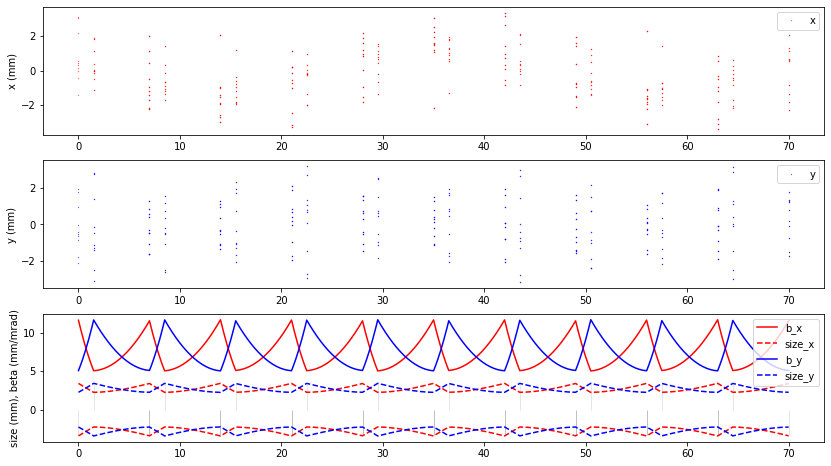

In [9]:
def doublet():
    LD1 = 1.5
    LD2 = 5.5
    F1 = 6
    F2 = -6
    QUADT(F1)
    DRIFT(LD1,15)
    QUADT(F2/2)
    DRIFT(LD2,15)
    QUADT(F1)
    

#def track_size_beta(betax0, alphax0, emitx0, betay0, alphay0, emity0, betaz0, alphaz0, emitz0, lattice, npart):
global full_twiss_array; full_twiss_array=np.zeros((20, 0))
global twiss
global MX; MX = np.eye(2)
global MY; MY = np.eye(2)
global MZ; MZ = np.eye(2)
global distx
global disty
global distz
global trk; trk = True
global plot_trk; plot_trk = True

if trk and plot_trk:
    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    ax1.figure.set_size_inches(14, 8)
else:
    fig, ax3 = plt.subplots()
    ax3.figure.set_size_inches(14, 5)


alphax0 = .8
betax0 = 11.6
emitx0 = 1
alphay0 = -0.8
betay0 = 5.06
emity0 = 1
alphaz0 = 0
betaz0 = 1
emitz0 = 1

twiss=twiss_set(betax0, alphax0, emitx0, 
                betay0, alphay0, emity0,
                betaz0, alphaz0, emitz0)

npart = 10

#create_nd(dist_type: str = 'KV', nD: int=4, npart: int = 1000, 
#              emit1: float = 1, alpha1: float = 0, beta1: float = 1, 
#              emit2: float = 1, alpha2: float = 0, beta2: float = 1, 
#              emit3: float = 1, alpha3: float = 0, beta3: float = 1) -> list:


dummy_dist = create_nd('KV', 4, npart, emitx0, alphax0, betax0, emity0, alphay0, betay0)
distx = dummy_dist[:,0:2].T
disty = dummy_dist[:,2:4].T


ncell = 10
for i in range(1,ncell+1):
    doublet()
    if i==1:   
        a_dummy, b_dummy = twiss_matched(MX)
        print('matched input: alpha_x: {:.3e}, beta_x: {:.3e}'.format(a_dummy, b_dummy))
        a_dummy, b_dummy = twiss_matched(MY)
        print('matched input: alpha_y: {:.3e}, beta_y: {:.3e}'.format(a_dummy, b_dummy))
        print('Phase advances per period:'), 
        phase_advance(MX, True, True), 
        phase_advance(MY, True, True);

plot_twiss();
#plot_emit()
    


#track_size_beta(betax0, alphax0, emitx0, betay0, alphay0, emity0, betaz0, alphaz0, emitz0, doublet, 100)


# A FoDo lattice using thick quadrupoles: A Focusing quad (in x), followed by a drift, then a Defocusing quad (in x, and with the same focal length), and then a drift of similar length

Matched input beam x:
matched parameter: alpha: 1.184e-15, beta: 3.999e+01
Matched input beam y:
matched parameter: alpha: -2.959e-15, beta: 2.277e-01
Phase advances per period:
mu: 163.656 (deg)
mu: 163.656 (deg)


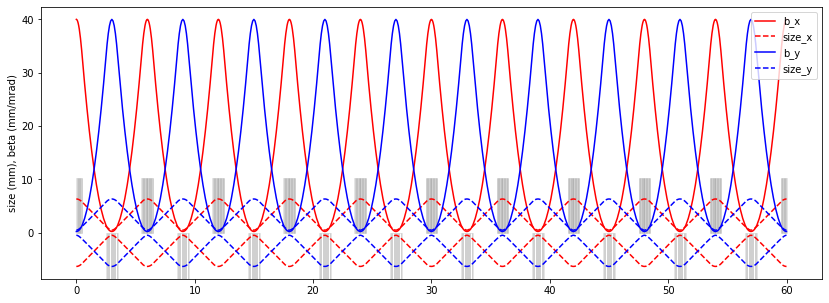

In [22]:
global full_twiss_array; full_twiss_array=np.zeros((20, 0))
global twiss
global MX; MX = np.eye(2)
global MY; MY = np.eye(2)
global MZ; MZ = np.eye(2)
global distx
global disty
global distz
global trk; trk = True
global plot_trk; plot_trk = False

if trk and plot_trk:
    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    ax1.figure.set_size_inches(14, 8)
else:
    fig, ax3 = plt.subplots()
    ax3.figure.set_size_inches(14, 5)

alphax0 = 0
betax0 = 40
emitx = 0.25
alphay0 = 0
betay0 = 0.2277
emity = 0.25
alphaz0 = 0
betaz0 = 1
emitz0 = 1


npart = 20
dummy_dist = create_nd('KV', 4, npart, emitx0, alphax0, betax0, emity0, alphay0, betay0)
distx = dummy_dist[:,0:2].T
disty = dummy_dist[:,2:4].T
twiss=twiss_set(betax0, alphax0, emitx0, 
                betay0, alphay0, emity0,
                betaz0, alphaz0, emitz0)

LQ = 1
KQ = 0.75
LD1 = 2
LD2 = 2

ncell = 10
for i in range(1,ncell+1):
    QUADK(LQ/2,KQ,10)
    DRIFT(LD1,10)
    QUADK(LQ,-KQ,10)
    DRIFT(LD2,10)
    QUADK(LQ/2,KQ,10)
    if i==1:        
        print('Matched input beam x:'), twiss_matched(MX);
        print('Matched input beam y:'), twiss_matched(MY);
        print('Phase advances per period:'), phase_advance(MX, True, True), phase_advance(MY, True, True);
plot_twiss()

In [23]:
phase_Adv_demonstrator()

interactive(children=(IntSlider(value=0, description='position', max=549), RadioButtons(description='mode', op…

# A Doublet lattice with different phase advances in x and y: Two quadrupoles near each other followed by a longer drift space

Matched input beam:
matched parameter: alpha: nan, beta: nan
Phase advances per period:
mu: 16.152 (deg)
mu: 24.784 (deg)


/var/folders/bx/56v6kp2d5_92q0tt7xkk6_l00000gq/T/ipykernel_55927/3565016041.py:8: RuntimeWarning: invalid value encountered in double_scalars
  twiss_alpha = lambda m00, m11, mu: (m00-m11)/(2*np.sin(mu))
/var/folders/bx/56v6kp2d5_92q0tt7xkk6_l00000gq/T/ipykernel_55927/3565016041.py:9: RuntimeWarning: invalid value encountered in double_scalars
  twiss_beta = lambda m01, mu: m01/np.sin(mu)


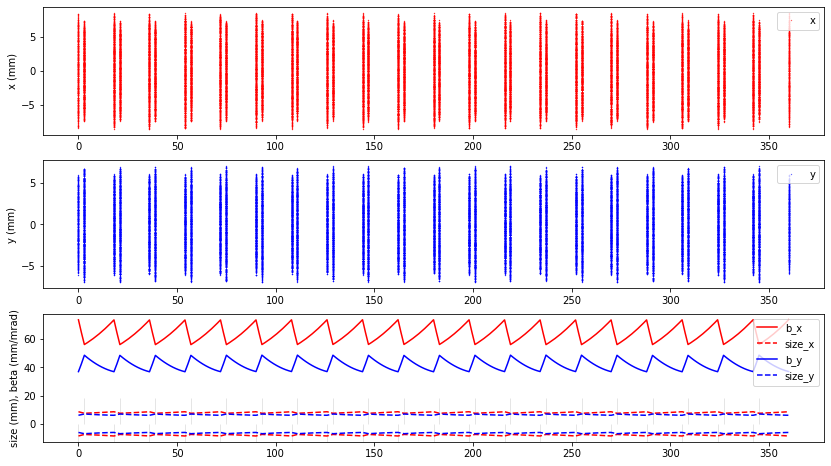

In [24]:
global full_twiss_array; full_twiss_array=np.zeros((20, 0))
global twiss
global MX; MX = np.eye(2)
global MY; MY = np.eye(2)
global MZ; MZ = np.eye(2)
global distx
global disty
global distz
global trk; trk = True
global plot_trk; plot_trk = True

if trk and plot_trk:
    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    ax1.figure.set_size_inches(14, 8)
else:
    fig, ax3 = plt.subplots()
    ax3.figure.set_size_inches(14, 5)

alphax0 = -0.74
betax0 = 73.7
emitx = 0.1
alphay0 = 0.18
betay0 = 37
emity = 0.1
alphaz0 = 0
betaz0 = 1
emitz0 = 1


npart = 1000
dummy_dist = create_nd('KV', 4, npart, emitx0, alphax0, betax0, emity0, alphay0, betay0)
distx = dummy_dist[:,0:2].T
disty = dummy_dist[:,2:4].T
twiss=twiss_set(betax0, alphax0, emitx0, 
                betay0, alphay0, emity0,
                betaz0, alphaz0, emitz0)

LD1 = 3
LD2 = 15
F1 = 19
F2 = -18
ncell = 20
for i in range(1,ncell+1):
    QUADT(F1)
    DRIFT(LD1,10)
    QUADT(F2)
    DRIFT(LD2,10)
    if i==1:        
        print('Matched input beam:'), twiss_matched();
        print('Phase advances per period:'), phase_advance(MX, True, True), phase_advance(MY, True, True);
        
plot_twiss()

# A Triplet lattice: Two quadrupoles with identical focal lengths sandwithing a quad with opposite polarity and half the focal length followed by a longer drift space which includes a dipole
#If the total angle is 360 degrees, we have made a closed orbit

Matched input beam:
matched parameter: alpha: nan, beta: nan
Phase advances per period:
mu: 45.578 (deg)
mu: 53.868 (deg)


/var/folders/bx/56v6kp2d5_92q0tt7xkk6_l00000gq/T/ipykernel_55927/3565016041.py:8: RuntimeWarning: invalid value encountered in double_scalars
  twiss_alpha = lambda m00, m11, mu: (m00-m11)/(2*np.sin(mu))
/var/folders/bx/56v6kp2d5_92q0tt7xkk6_l00000gq/T/ipykernel_55927/3565016041.py:9: RuntimeWarning: invalid value encountered in double_scalars
  twiss_beta = lambda m01, mu: m01/np.sin(mu)


Total length: 273.745 m
Total angle: 6.283 rad


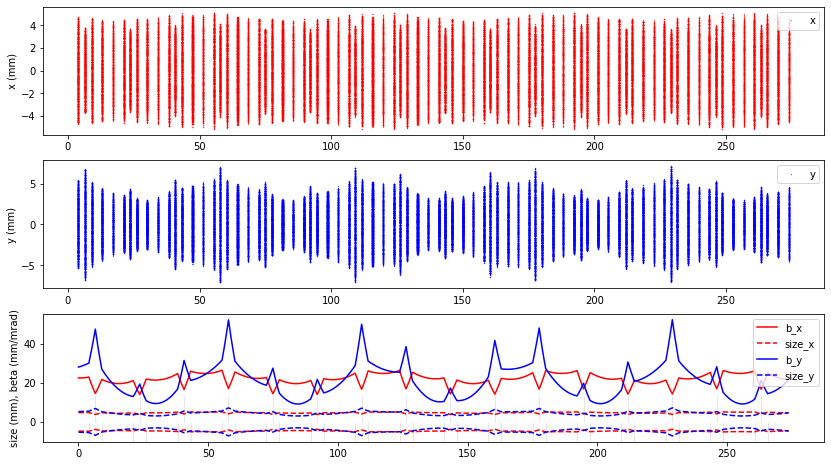

In [25]:
global full_twiss_array; full_twiss_array=np.zeros((20, 0))
global twiss
global MX; MX = np.eye(2)
global MY; MY = np.eye(2)
global MZ; MZ = np.eye(2)
global distx
global disty
global distz
global trk; trk = True
global plot_trk; plot_trk = True

if trk and plot_trk:
    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    ax1.figure.set_size_inches(14, 8)
else:
    fig, ax3 = plt.subplots()
    ax3.figure.set_size_inches(14, 5)

alphax0 = 0.029
betax0 = 22.6
emitx = 1
alphay0 = -0.18
betay0 = 28.2
emity = 1
alphaz0 = 0
betaz0 = 1
emitz0 = 1


npart = 1000
dummy_dist = create_nd('KV', 4, npart, emitx0, alphax0, betax0, emity0, alphay0, betay0)
distx = dummy_dist[:,0:2].T
disty = dummy_dist[:,2:4].T
twiss=twiss_set(betax0, alphax0, emitx0, 
                betay0, alphay0, emity0,
                betaz0, alphaz0, emitz0)
F1 = 11
LD1 = 2.5
LD2 = 4.
TSB = 2*np.pi/16
RSB = 100/2/np.pi

ncell = 16

#plot_emit()

for i in range(1,ncell+1):

    DRIFT(LD2,10)
    QUADT(F1)
    DRIFT(LD1,10)
    QUADT(-F1/2)
    DRIFT(LD1,10)
    QUADT(F1)
    DRIFT(LD2,10)
    BEND(TSB, RSB, 0, 0, 0, 10)
    DRIFT(LD2,10)
    if i==1:        
        print('Matched input beam:'), twiss_matched();
        print('Phase advances per period:'), phase_advance(MX, True, True), phase_advance(MY, True, True);
print('Total length: {:0.3f} m'.format(full_twiss_array[0,-1]))
print('Total angle: {:0.3f} rad'.format(ncell*TSB))

plot_twiss()

# A Triplet lattice: Two quadrupoles with identical focal lengths sandwithing a quad with opposite polarity with shorter focal length followed by a longer drift space, beam is symmetric in the long drift space

Matched input beam:
matched parameter: alpha: nan, beta: nan
Phase advances per period:
mu: 38.051 (deg)
mu: 34.911 (deg)


/var/folders/bx/56v6kp2d5_92q0tt7xkk6_l00000gq/T/ipykernel_55927/3565016041.py:8: RuntimeWarning: invalid value encountered in double_scalars
  twiss_alpha = lambda m00, m11, mu: (m00-m11)/(2*np.sin(mu))
/var/folders/bx/56v6kp2d5_92q0tt7xkk6_l00000gq/T/ipykernel_55927/3565016041.py:9: RuntimeWarning: invalid value encountered in double_scalars
  twiss_beta = lambda m01, mu: m01/np.sin(mu)


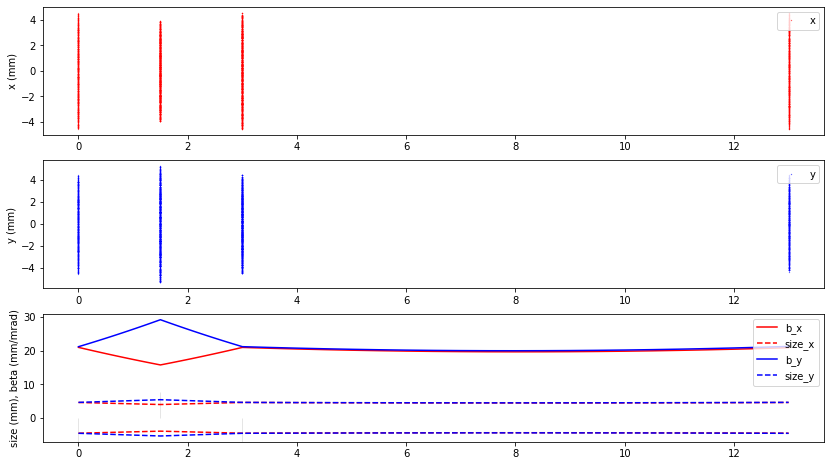

In [26]:
global full_twiss_array; full_twiss_array=np.zeros((20, 0))
global twiss
global MX; MX = np.eye(2)
global MY; MY = np.eye(2)
global MZ; MZ = np.eye(2)
global distx
global disty
global distz
global trk; trk = True
global plot_trk; plot_trk = True

if trk and plot_trk:
    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    ax1.figure.set_size_inches(14, 8)
else:
    fig, ax3 = plt.subplots()
    ax3.figure.set_size_inches(14, 5)

alphax0 = -0.254
betax0 = 21
emit_nx = 1
alphay0 = -0.25
betay0 = 21.2
emit_ny = 1
alphaz0 = 0
betaz0 = 1
emitz0 = 1


npart = 1000
dummy_dist = create_nd('KV', 4, npart, emitx0, alphax0, betax0, emity0, alphay0, betay0)
distx = dummy_dist[:,0:2].T
disty = dummy_dist[:,2:4].T
twiss=twiss_set(betax0, alphax0, emitx0, 
                betay0, alphay0, emity0,
                betaz0, alphaz0, emitz0)

F1 = 9.7
F2 = -10
LD1 = 1.5
LD2 = 10

ncell = 1
for i in range(1,ncell+1):
    QUADT(F1)
    DRIFT(LD1,20)
    QUADT(F2/2)
    DRIFT(LD1,20)
    QUADT(F1)
    DRIFT(LD2,20)
    if i==1:        
        print('Matched input beam:'), twiss_matched();
        print('Phase advances per period:'), phase_advance(MX, True, True), phase_advance(MY, True, True);        
        
plot_twiss()

# An FFDD lattice, two identical quadrupoles are followed by another pair of identical quadrupoles which have opposite polarity

Matched input beam:
matched parameter: alpha: nan, beta: nan
Phase advances per period:
mu: 24.460 (deg)
mu: 24.460 (deg)


/var/folders/bx/56v6kp2d5_92q0tt7xkk6_l00000gq/T/ipykernel_55927/3565016041.py:8: RuntimeWarning: invalid value encountered in double_scalars
  twiss_alpha = lambda m00, m11, mu: (m00-m11)/(2*np.sin(mu))
/var/folders/bx/56v6kp2d5_92q0tt7xkk6_l00000gq/T/ipykernel_55927/3565016041.py:9: RuntimeWarning: invalid value encountered in double_scalars
  twiss_beta = lambda m01, mu: m01/np.sin(mu)


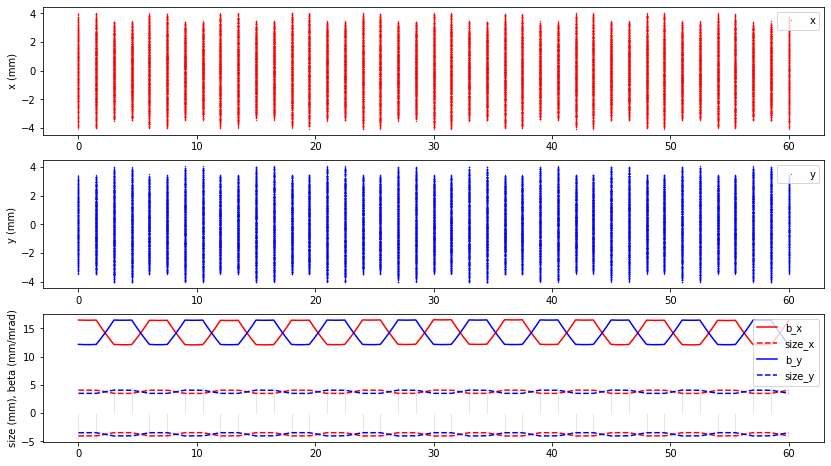

In [27]:
global full_twiss_array; full_twiss_array=np.zeros((20, 0))
global twiss
global MX; MX = np.eye(2)
global MY; MY = np.eye(2)
global MZ; MZ = np.eye(2)
global distx
global disty
global distz
global trk; trk = True
global plot_trk; plot_trk = True

if trk and plot_trk:
    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    ax1.figure.set_size_inches(14, 8)
else:
    fig, ax3 = plt.subplots()
    ax3.figure.set_size_inches(14, 5)

alphax0 = -1.6
betax0 = 16.49
emit_nx = 1
alphay0 = 1.28
betay0 = 12.17
emit_ny = 1
alphaz0 = 0
betaz0 = 1
emitz0 = 1


npart = 1000
dummy_dist = create_nd('KV', 4, npart, emitx0, alphax0, betax0, emity0, alphay0, betay0)
distx = dummy_dist[:,0:2].T
disty = dummy_dist[:,2:4].T
twiss=twiss_set(betax0, alphax0, emitx0, 
                betay0, alphay0, emity0,
                betaz0, alphaz0, emitz0)

F1 = 10
F2 = -10
LD1 = 1.5
LD2 = 4.5

ncell = 10

for i in range(1,ncell+1):

    QUADT(F1)
    DRIFT(LD1,20)
    QUADT(F1)
    DRIFT(LD1,20)
    QUADT(F2)
    DRIFT(LD1,20)
    QUADT(F2)
    DRIFT(LD1,20)

    if i==1:        
        print('Matched input beam:'), twiss_matched();
        print('Phase advances per period:'), phase_advance(MX, True, True), phase_advance(MY, True, True);        
        
plot_twiss()

In [28]:
wg.interact(dist_alpha, emitxv=(1, 51, 5), alphaxv=(-10,10,0.5), betaxv=(10, 1010, 50));


interactive(children=(IntSlider(value=26, description='emitxv', max=51, min=1, step=5), FloatSlider(value=0.0,…

In [29]:
element_action_demonstrator()

interactive(children=(IntSlider(value=0, description='position', max=919), Output()), _dom_classes=('widget-in…

In [30]:
phase_Adv_demonstrator()

interactive(children=(IntSlider(value=0, description='position', max=919), RadioButtons(description='mode', op…